In [96]:
import pandas as pd
import numpy as np
import json
import glob
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

from autogluon.tabular import TabularDataset, TabularPredictor

In [97]:
%run fitbit_generate_daily_hrv.ipynb
hrv_raw = pd.read_csv('./Fitbit/ShiYangLee/Sleep/daily_hrv_full.csv')
hrv_raw

,timestamp,rmssd,nremhr,entropy
0,2022-02-27T00:00:00,52.053,53.789,2.833
1,2022-02-28T00:00:00,61.281,49.983,2.935
2,2022-03-01T00:00:00,59.392,50.798,2.943
3,2022-03-02T00:00:00,56.437,54.837,2.829
4,2022-03-03T00:00:00,54.982,52.368,2.927
...,...,...,...,...
87,2022-05-31T00:00:00,47.665,56.233,2.883
88,2022-06-01T00:00:00,56.450,52.769,2.938
89,2022-06-02T00:00:00,51.455,56.017,2.938
90,2022-06-03T00:00:00,52.935,54.560,2.840


In [98]:
hrv_raw.set_index('timestamp', inplace = True)

In [99]:
hrv_raw.index = pd.to_datetime(hrv_raw.index, format = '%Y-%m-%d')
# hrv_raw.index = hrv_raw.index.to_series().dt.strftime('%Y-%m-%d')

<AxesSubplot:xlabel='timestamp'>

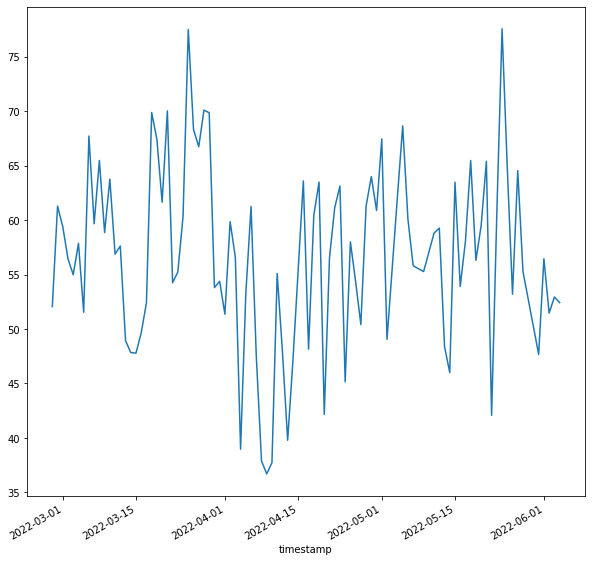

In [100]:
hrv_raw['rmssd'].plot()

In [101]:
hrv_raw['hrv_rolling'] = hrv_raw['rmssd'].rolling(7, 3, center = True).mean()

<AxesSubplot:xlabel='timestamp'>

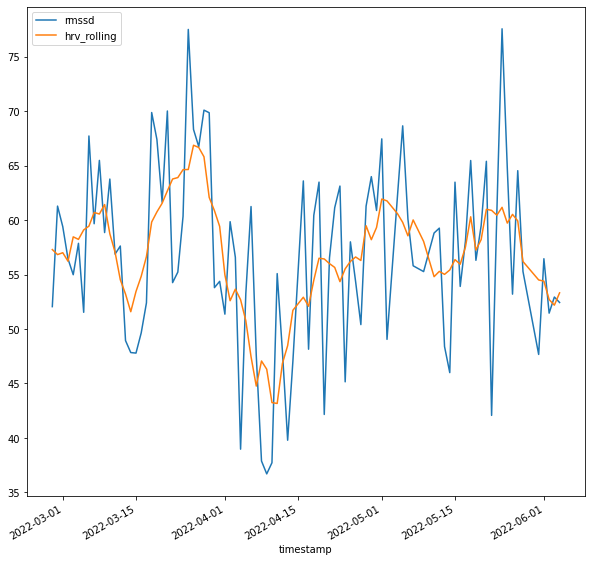

In [102]:
hrv_raw[['rmssd', 'hrv_rolling']].plot()

In [103]:
%run fitbit_generate_steps.ipynb
steps_raw = pd.read_csv('./Fitbit/ShiYangLee/Physical Activity/steps_full.csv')
steps_raw.head()

,dateTime,value
0,2022-02-26 22:15:00,0
1,2022-02-26 22:16:00,5
2,2022-02-26 22:17:00,0
3,2022-02-26 22:18:00,0
4,2022-02-26 22:19:00,0


In [104]:
steps_raw.set_index('dateTime', inplace = True)
steps_raw.index = pd.to_datetime(steps_raw.index)
steps_per_day = steps_raw.groupby(steps_raw.index.to_series().dt.date).sum()
steps_per_day.index = pd.to_datetime(steps_per_day.index)
steps_per_day.columns = ['steps']

In [105]:
steps_per_day.head()

,steps
dateTime,
2022-02-26,60
2022-02-27,2542
2022-02-28,6426
2022-03-01,9602
2022-03-02,7721


In [106]:
hrv = hrv_raw.merge(steps_per_day, left_index=True, right_index=True)

In [107]:
hrv['steps_normalized'] = hrv['steps']/100
hrv['steps_rolling'] = hrv['steps_normalized'].rolling(7, 3, center = True).mean()

<AxesSubplot:>

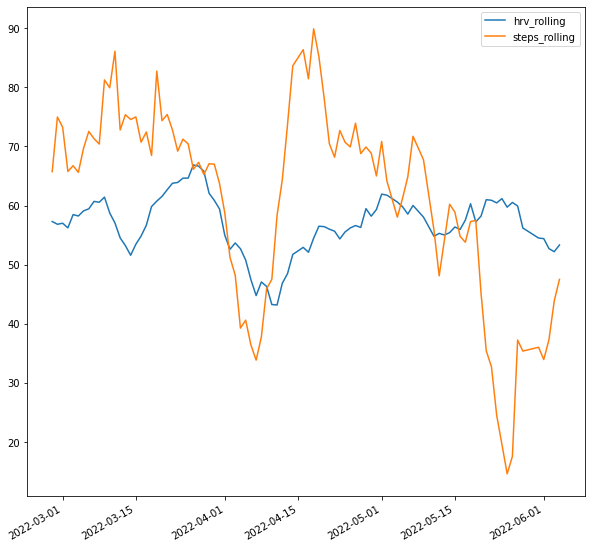

In [108]:
hrv[['hrv_rolling', 'steps_rolling']].plot()

In [109]:
sleep_dir = glob.glob('./Fitbit/ShiYangLee/Sleep/sleep-*.json')
dfs = []
for file in sleep_dir:
    data = pd.read_json(file)
    dfs.append(data)
sleep = pd.concat(dfs, ignore_index=True)
sleep.head()

,logId,dateOfSleep,startTime,endTime,duration,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,timeInBed,efficiency,type,infoCode,logType,levels,mainSleep
0,36651127171,2022-04-26,2022-04-25T23:59:00.000,2022-04-26T07:53:30.000,28440000,0,419,55,0,474,96,stages,0,auto_detected,"{'summary': {'deep': {'count': 4, 'minutes': 8...",True
1,36638185772,2022-04-25,2022-04-25T01:04:00.000,2022-04-25T07:43:30.000,23940000,0,339,60,6,399,95,stages,0,auto_detected,"{'summary': {'deep': {'count': 6, 'minutes': 7...",True
2,36625185402,2022-04-24,2022-04-23T22:20:30.000,2022-04-24T09:35:30.000,40500000,0,568,107,0,675,96,stages,0,auto_detected,"{'summary': {'deep': {'count': 5, 'minutes': 9...",True
3,36617451798,2022-04-23,2022-04-23T13:25:00.000,2022-04-23T14:56:00.000,5460000,0,80,11,0,91,88,classic,2,auto_detected,"{'summary': {'restless': {'count': 4, 'minutes...",False
4,36613912467,2022-04-23,2022-04-22T23:23:00.000,2022-04-23T11:20:30.000,43020000,0,623,94,0,717,93,stages,0,auto_detected,"{'summary': {'deep': {'count': 7, 'minutes': 1...",True


In [110]:
json_struct = json.loads(sleep.to_json(orient='records'))
sleep = pd.json_normalize(json_struct)

In [111]:
sleep.drop(['levels.data', 'levels.shortData'], axis=1, inplace=True)
sleep

,logId,dateOfSleep,startTime,endTime,duration,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,timeInBed,...,levels.summary.light.thirtyDayAvgMinutes,levels.summary.rem.count,levels.summary.rem.minutes,levels.summary.rem.thirtyDayAvgMinutes,levels.summary.restless.count,levels.summary.restless.minutes,levels.summary.awake.count,levels.summary.awake.minutes,levels.summary.asleep.count,levels.summary.asleep.minutes
0,36651127171,2022-04-26,2022-04-25T23:59:00.000,2022-04-26T07:53:30.000,28440000,0,419,55,0,474,...,271.0,6.0,89.0,101.0,NaN,NaN,NaN,NaN,NaN,NaN
1,36638185772,2022-04-25,2022-04-25T01:04:00.000,2022-04-25T07:43:30.000,23940000,0,339,60,6,399,...,273.0,5.0,61.0,103.0,NaN,NaN,NaN,NaN,NaN,NaN
2,36625185402,2022-04-24,2022-04-23T22:20:30.000,2022-04-24T09:35:30.000,40500000,0,568,107,0,675,...,271.0,14.0,143.0,101.0,NaN,NaN,NaN,NaN,NaN,NaN
3,36617451798,2022-04-23,2022-04-23T13:25:00.000,2022-04-23T14:56:00.000,5460000,0,80,11,0,91,...,NaN,NaN,NaN,NaN,4.0,10.0,1.0,1.0,0.0,80.0
4,36613912467,2022-04-23,2022-04-22T23:23:00.000,2022-04-23T11:20:30.000,43020000,0,623,94,0,717,...,269.0,12.0,153.0,99.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,37092507425,2022-05-31,2022-05-31T00:40:00.000,2022-05-31T08:39:00.000,28740000,0,425,54,1,479,...,251.0,4.0,133.0,143.0,NaN,NaN,NaN,NaN,NaN,NaN
120,37087272653,2022-05-30,2022-05-30T18:45:00.000,2022-05-30T19:54:30.000,4140000,0,64,5,0,69,...,NaN,NaN,NaN,NaN,2.0,5.0,0.0,0.0,0.0,64.0
121,37054307750,2022-05-28,2022-05-27T23:15:00.000,2022-05-28T09:38:00.000,37380000,0,548,75,6,623,...,235.0,12.0,154.0,138.0,NaN,NaN,NaN,NaN,NaN,NaN
122,37044773607,2022-05-27,2022-05-27T00:46:00.000,2022-05-27T09:15:30.000,30540000,0,470,39,0,509,...,208.0,9.0,113.0,162.0,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
sleep.to_csv('sleep_tmp.csv')

In [113]:
sleep = sleep[~sleep.duplicated(subset='logId', keep='last')]

In [114]:
sleep_duration_df = sleep.set_index('dateOfSleep')
sleep_duration_df.index = pd.to_datetime(sleep_duration_df.index)
print(sleep_duration_df.index.dtype)
sleep_duration_df = sleep_duration_df['minutesAsleep'].groupby(sleep_duration_df.index.to_series().dt.date).sum()

datetime64[ns]


In [115]:
sleep_duration_df.sort_index(inplace = True)

In [116]:
hrv = hrv.merge(sleep_duration_df, left_index=True, right_index=True)

In [117]:
hrv['minutesAsleep_normalized'] = hrv['minutesAsleep']/10
hrv['minutesAsleep_rolling'] = hrv['minutesAsleep_normalized'].rolling(7, 3, center=True)\
                                .mean()
hrv.head()

,rmssd,nremhr,entropy,hrv_rolling,steps,steps_normalized,steps_rolling,minutesAsleep,minutesAsleep_normalized,minutesAsleep_rolling
2022-02-27,52.053,53.789,2.833,57.290750,2542,25.42,65.727500,395,39.5,35.950000
2022-02-28,61.281,49.983,2.935,56.829000,6426,64.26,74.984000,328,32.8,34.500000
2022-03-01,59.392,50.798,2.943,57.001500,9602,96.02,73.248333,321,32.1,35.333333
2022-03-02,56.437,54.837,2.829,56.220143,7721,77.21,65.765714,394,39.4,38.057143
2022-03-03,54.982,52.368,2.927,58.457857,11201,112.01,66.738571,287,28.7,39.114286


<AxesSubplot:>

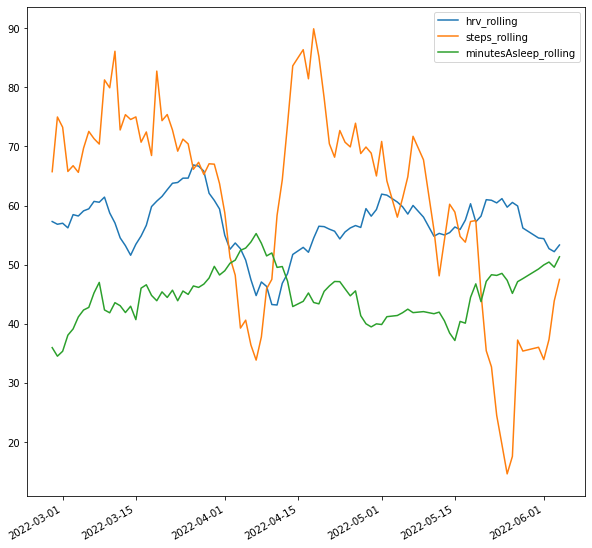

In [118]:
hrv[['hrv_rolling', 'steps_rolling', 'minutesAsleep_rolling']].plot()

In [119]:
def get_hrz_df():
    hrz_dir = glob.glob('./Fitbit/ShiYangLee/Physical Activity/time_in_heart_rate_zones-*.json')
    dfs = []
    for file in hrz_dir:
        tmp = pd.read_json(file, orient='values')
        dfs.append(tmp)
    hrz_df = pd.concat(dfs, ignore_index=True)
    hrz_df = pd.concat([hrz_df, pd.json_normalize(hrz_df['value'])], axis=1)
    hrz_df.drop('value', axis=1, inplace=True)
    hrz_df.set_index('dateTime', inplace=True)
    hrz_df.sort_index(inplace=True)
    hrz_df.rename(columns = {'valuesInZones.BELOW_DEFAULT_ZONE_1':'Resting_minutes', \
                             'valuesInZones.IN_DEFAULT_ZONE_1':'Fat_burn_minutes', \
                             'valuesInZones.IN_DEFAULT_ZONE_2':'Cardio_minutes', \
                             'valuesInZones.IN_DEFAULT_ZONE_3':'Peak_minutes'}, \
                  inplace=True)
    return hrz_df

In [120]:
hrz_df = get_hrz_df()
hrz_df.head()

,Fat_burn_minutes,Cardio_minutes,Peak_minutes,Resting_minutes
dateTime,,,,
2022-02-26,0.0,0.0,0.0,109.0
2022-02-27,49.0,2.0,0.0,1375.0
2022-02-28,74.0,1.0,0.0,1327.0
2022-03-01,301.0,2.0,0.0,1133.0
2022-03-02,63.0,0.0,0.0,1318.0


In [121]:
hrv = hrv.merge(hrz_df, left_index=True, right_index=True)

In [122]:
hrv

,rmssd,nremhr,entropy,hrv_rolling,steps,steps_normalized,steps_rolling,minutesAsleep,minutesAsleep_normalized,minutesAsleep_rolling,Fat_burn_minutes,Cardio_minutes,Peak_minutes,Resting_minutes
2022-02-27,52.053,53.789,2.833,57.290750,2542,25.42,65.727500,395,39.5,35.950000,49.0,2.0,0.0,1375.0
2022-02-28,61.281,49.983,2.935,56.829000,6426,64.26,74.984000,328,32.8,34.500000,74.0,1.0,0.0,1327.0
2022-03-01,59.392,50.798,2.943,57.001500,9602,96.02,73.248333,321,32.1,35.333333,301.0,2.0,0.0,1133.0
2022-03-02,56.437,54.837,2.829,56.220143,7721,77.21,65.765714,394,39.4,38.057143,63.0,0.0,0.0,1318.0
2022-03-03,54.982,52.368,2.927,58.457857,11201,112.01,66.738571,287,28.7,39.114286,134.0,0.0,0.0,1261.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,47.665,56.233,2.883,54.501571,2925,29.25,36.010000,425,42.5,49.257143,48.0,0.0,0.0,1199.0
2022-06-01,56.450,52.769,2.938,54.392000,15028,150.28,33.932857,334,33.4,49.942857,519.0,5.0,0.0,908.0
2022-06-02,51.455,56.017,2.938,52.701833,563,5.63,37.328333,573,57.3,50.433333,3.0,0.0,0.0,862.0
2022-06-03,52.935,54.560,2.840,52.187200,3215,32.15,43.846000,619,61.9,49.560000,187.0,13.0,0.0,1044.0


In [123]:
lag_list = ['steps', 'minutesAsleep', 'Cardio_minutes', 'Resting_minutes', \
            'Peak_minutes', 'Fat_burn_minutes', 'rmssd']
def get_lag(df, lag_list, num_lag = 10):
    for col in lag_list:
        df = df.join([df[col].shift(x).rename(f"{col}_lag{x}") \
                      for x in range(1, num_lag+1)])
    return df

In [124]:
lag_df = get_lag(hrv, lag_list)
lag_df.head()
lag_df.to_csv('hrv_features_data.csv')

In [125]:
def get_partial_date(df, num):
    duration = df.index[-1] - df.index[0]
    return pd.to_datetime(df.index[0] + num * pd.to_timedelta(duration))

In [126]:
split_date = get_partial_date(lag_df, 0.7)
fearue_df = lag_df.drop(columns=['rmssd', 'nremhr', 'entropy', 'hrv_rolling', 'steps_normalized', \
                       'steps_rolling', 'minutesAsleep_normalized', 'minutesAsleep_rolling'])
fearue_df = fearue_df.interpolate(limit_direction='backward')
target_df = lag_df['rmssd']

train_feature_df = fearue_df[fearue_df.index < split_date]
train_target_df = target_df[target_df.index < split_date]

test_feature_df = fearue_df[fearue_df.index >= split_date]
test_target_df = target_df[target_df.index >= split_date]

In [127]:
model = LinearRegression(positive=True)
model.fit(X= train_feature_df, y = train_target_df)
lag_df_pred = model.predict(test_feature_df)
train_pred = model.predict(train_feature_df)

In [128]:
lag_df_pred

array([ 21.4760811 ,  29.58051799,   5.07399493,  49.88034677,
        26.88276033,   3.32142635,  19.71257407,   4.001742  ,
        31.23574041,  28.49397365,  30.95724303,  19.25458662,
        23.97663512,  41.23938159,   4.81121581,  31.24529391,
        28.51225889,  47.72197601,  37.13287846,  55.83223294,
        32.45460002,  40.07110786,  43.10763371,  40.67618983,
        41.78430693, -20.36163224])

In [129]:
if not isinstance(train_target_df, pd.DataFrame):
    train_target_df = train_target_df.to_frame()
if not isinstance(test_target_df,  pd.DataFrame):
    test_target_df = test_target_df.to_frame()
train_target_df['pred'] = train_pred
test_target_df['pred'] = lag_df_pred
final_df = pd.concat([train_target_df, test_target_df])

In [130]:
model.score(test_feature_df, test_target_df['rmssd'])

-20.537318991809833

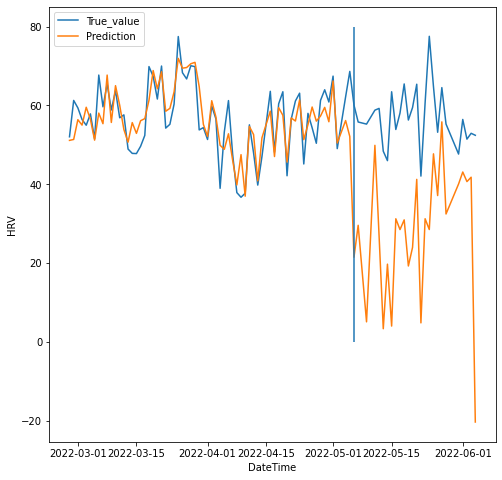

In [131]:
plt.rcParams["figure.figsize"] = (8, 8)
plt.plot(final_df, label = ['True_value','Prediction'])
plt.xlabel('DateTime')
plt.ylabel('HRV')
plt.vlines(split_date, ymin=0, ymax=80)
plt.legend()
plt.savefig('HRV_prediction.jpeg')
plt.show()

In [132]:
pd.set_option('display.max_rows', 10)
coef = pd.DataFrame(zip(train_feature_df.columns, model.coef_), columns = ['variables', 'coefficients'])
coef = coef.sort_values('coefficients', ascending=False)
coef.head(10)

,variables,coefficients
53,Peak_minutes_lag8,3.845761
49,Peak_minutes_lag4,2.655873
3,Cardio_minutes,1.277758
54,Peak_minutes_lag9,0.937208
27,Cardio_minutes_lag2,0.542156
32,Cardio_minutes_lag7,0.440441
34,Cardio_minutes_lag9,0.398409
28,Cardio_minutes_lag3,0.245885
35,Cardio_minutes_lag10,0.233890
4,Peak_minutes,0.145260


In [133]:
bar = lag_df[coef['variables'][:10]]

In [134]:
bar

,Peak_minutes_lag8,Peak_minutes_lag4,Cardio_minutes,Peak_minutes_lag9,Cardio_minutes_lag2,Cardio_minutes_lag7,Cardio_minutes_lag9,Cardio_minutes_lag3,Cardio_minutes_lag10,Peak_minutes
2022-02-27,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2022-02-28,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2022-03-01,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,NaN,0.0
2022-03-02,NaN,NaN,0.0,NaN,1.0,NaN,NaN,2.0,NaN,0.0
2022-03-03,NaN,0.0,0.0,NaN,2.0,NaN,NaN,1.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...
2022-05-31,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
2022-06-01,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
2022-06-02,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-03,0.0,0.0,13.0,8.0,5.0,3.0,4.0,0.0,0.0,0.0


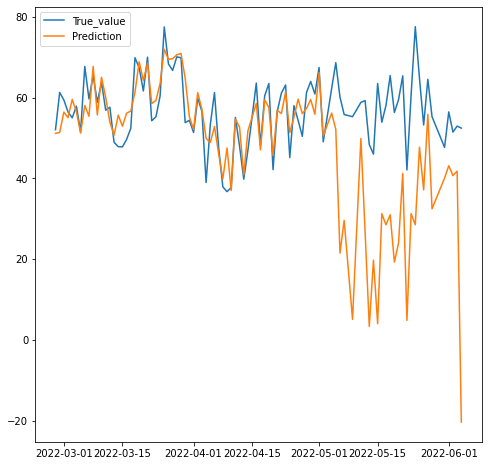

<Figure size 576x576 with 0 Axes>

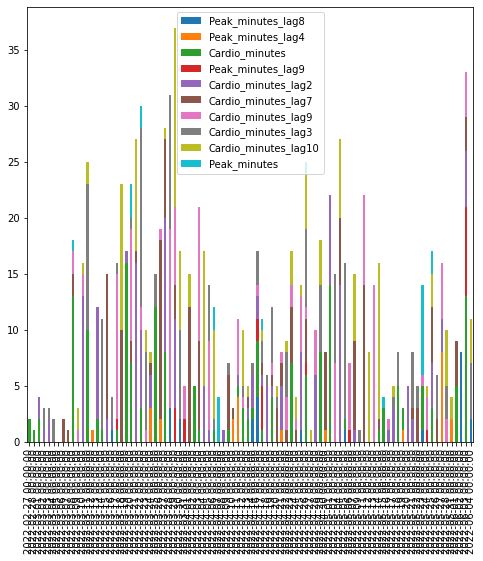

In [135]:
plt.figure(1)
plt.plot(final_df, label = ['True_value','Prediction'])
plt.legend()
plt.show()
plt.figure(2)
bar.plot(kind='bar', stacked=True)
plt.legend()
plt.show()

In [136]:
normalized_df=(lag_df-lag_df.min())/(lag_df.max()-lag_df.min())

In [137]:
split_date = get_partial_date(lag_df, 0.7)
norm_fearue_df = lag_df.drop(columns=['rmssd', 'nremhr', 'entropy', 'hrv_rolling', 'steps_normalized', \
                       'steps_rolling', 'minutesAsleep_normalized', 'minutesAsleep_rolling'])
norm_fearue_df = norm_fearue_df.interpolate(limit_direction='backward')
norm_target_df = normalized_df['rmssd']

norm_train_feature_df = norm_fearue_df[fearue_df.index < split_date]
norm_train_target_df = norm_target_df[target_df.index < split_date]

norm_test_feature_df = norm_fearue_df[fearue_df.index >= split_date]
norm_test_target_df = norm_target_df[target_df.index >= split_date]

In [138]:
norm_model = LinearRegression(positive=True)
norm_model.fit(X= norm_train_feature_df, y = norm_train_target_df)
norm_lag_df_pred = norm_model.predict(norm_test_feature_df)
norm_train_pred = norm_model.predict(norm_train_feature_df)

In [139]:
if not isinstance(norm_train_target_df, pd.DataFrame):
    norm_train_target_df = norm_train_target_df.to_frame()
if not isinstance(norm_test_target_df,  pd.DataFrame):
    norm_test_target_df = norm_test_target_df.to_frame()
norm_train_target_df['pred'] = norm_train_pred
norm_test_target_df['pred'] = norm_lag_df_pred
norm_final_df = pd.concat([norm_train_target_df, norm_test_target_df])

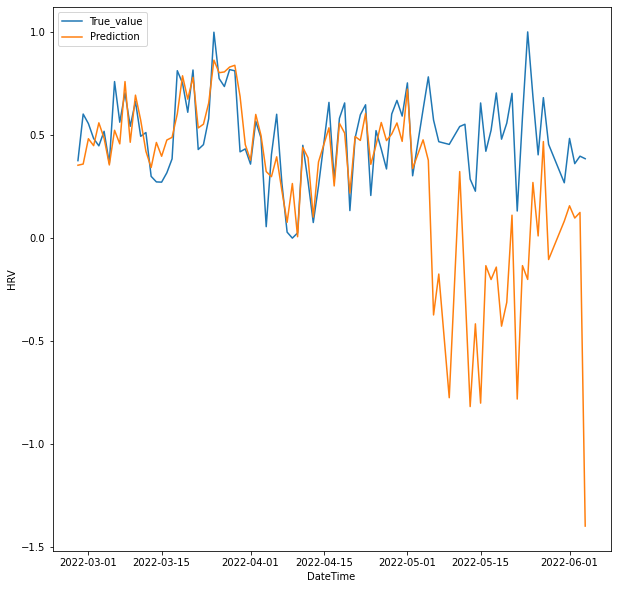

In [140]:
plt.rcParams["figure.figsize"] = (10, 10)
plt.plot(norm_final_df, label = ['True_value','Prediction'])
plt.xlabel('DateTime')
plt.ylabel('HRV')
# plt.vlines(split_date, ymin=0, ymax=80)
plt.legend()
plt.savefig('HRV_prediction.jpeg')
plt.show()

In [141]:
norm_coef = pd.DataFrame(zip(norm_train_feature_df.columns, norm_model.coef_), columns = ['variables', 'coefficients'])
norm_coef = norm_coef.sort_values('coefficients', ascending=False)
norm_coef.head(10)

,variables,coefficients
53,Peak_minutes_lag8,0.094125
49,Peak_minutes_lag4,0.065003
3,Cardio_minutes,0.031273
54,Peak_minutes_lag9,0.022938
27,Cardio_minutes_lag2,0.013269
32,Cardio_minutes_lag7,0.010780
34,Cardio_minutes_lag9,0.009751
28,Cardio_minutes_lag3,0.006018
35,Cardio_minutes_lag10,0.005724
4,Peak_minutes,0.003555


In [142]:
for i in range(1, 11):
    print(f"Lag {i} correlation is: ", lag_df['rmssd'].autocorr(lag=i))

Lag 1 correlation is:  0.34025622457976207
Lag 2 correlation is:  0.13093410406826045
Lag 3 correlation is:  0.2899652330054049
Lag 4 correlation is:  0.17777560211414647
Lag 5 correlation is:  0.01891563472475311
Lag 6 correlation is:  0.12297582512597087
Lag 7 correlation is:  -0.027419420021947822
Lag 8 correlation is:  0.01314137893812063
Lag 9 correlation is:  0.09586721928741726
Lag 10 correlation is:  -0.10188226779722838


In [143]:
lag_df

,rmssd,nremhr,entropy,hrv_rolling,steps,steps_normalized,steps_rolling,minutesAsleep,minutesAsleep_normalized,minutesAsleep_rolling,...,rmssd_lag1,rmssd_lag2,rmssd_lag3,rmssd_lag4,rmssd_lag5,rmssd_lag6,rmssd_lag7,rmssd_lag8,rmssd_lag9,rmssd_lag10
2022-02-27,52.053,53.789,2.833,57.290750,2542,25.42,65.727500,395,39.5,35.950000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-28,61.281,49.983,2.935,56.829000,6426,64.26,74.984000,328,32.8,34.500000,...,52.053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01,59.392,50.798,2.943,57.001500,9602,96.02,73.248333,321,32.1,35.333333,...,61.281,52.053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-02,56.437,54.837,2.829,56.220143,7721,77.21,65.765714,394,39.4,38.057143,...,59.392,61.281,52.053,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-03,54.982,52.368,2.927,58.457857,11201,112.01,66.738571,287,28.7,39.114286,...,56.437,59.392,61.281,52.053,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,47.665,56.233,2.883,54.501571,2925,29.25,36.010000,425,42.5,49.257143,...,55.275,64.533,53.198,64.780,77.557,60.643,42.069,65.393,59.480,56.305
2022-06-01,56.450,52.769,2.938,54.392000,15028,150.28,33.932857,334,33.4,49.942857,...,47.665,55.275,64.533,53.198,64.780,77.557,60.643,42.069,65.393,59.480
2022-06-02,51.455,56.017,2.938,52.701833,563,5.63,37.328333,573,57.3,50.433333,...,56.450,47.665,55.275,64.533,53.198,64.780,77.557,60.643,42.069,65.393
2022-06-03,52.935,54.560,2.840,52.187200,3215,32.15,43.846000,619,61.9,49.560000,...,51.455,56.450,47.665,55.275,64.533,53.198,64.780,77.557,60.643,42.069


In [144]:
poly = PolynomialFeatures(2)

In [145]:
fearue_df

,steps,minutesAsleep,Fat_burn_minutes,Cardio_minutes,Peak_minutes,Resting_minutes,steps_lag1,steps_lag2,steps_lag3,steps_lag4,...,rmssd_lag1,rmssd_lag2,rmssd_lag3,rmssd_lag4,rmssd_lag5,rmssd_lag6,rmssd_lag7,rmssd_lag8,rmssd_lag9,rmssd_lag10
2022-02-27,2542,395,49.0,2.0,0.0,1375.0,2542.0,2542.0,2542.0,2542.0,...,52.053,52.053,52.053,52.053,52.053,52.053,52.053,52.053,52.053,52.053
2022-02-28,6426,328,74.0,1.0,0.0,1327.0,2542.0,2542.0,2542.0,2542.0,...,52.053,52.053,52.053,52.053,52.053,52.053,52.053,52.053,52.053,52.053
2022-03-01,9602,321,301.0,2.0,0.0,1133.0,6426.0,2542.0,2542.0,2542.0,...,61.281,52.053,52.053,52.053,52.053,52.053,52.053,52.053,52.053,52.053
2022-03-02,7721,394,63.0,0.0,0.0,1318.0,9602.0,6426.0,2542.0,2542.0,...,59.392,61.281,52.053,52.053,52.053,52.053,52.053,52.053,52.053,52.053
2022-03-03,11201,287,134.0,0.0,0.0,1261.0,7721.0,9602.0,6426.0,2542.0,...,56.437,59.392,61.281,52.053,52.053,52.053,52.053,52.053,52.053,52.053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,2925,425,48.0,0.0,0.0,1199.0,474.0,1356.0,1646.0,2765.0,...,55.275,64.533,53.198,64.780,77.557,60.643,42.069,65.393,59.480,56.305
2022-06-01,15028,334,519.0,5.0,0.0,908.0,2925.0,474.0,1356.0,1646.0,...,47.665,55.275,64.533,53.198,64.780,77.557,60.643,42.069,65.393,59.480
2022-06-02,563,573,3.0,0.0,0.0,862.0,15028.0,2925.0,474.0,1356.0,...,56.450,47.665,55.275,64.533,53.198,64.780,77.557,60.643,42.069,65.393
2022-06-03,3215,619,187.0,13.0,0.0,1044.0,563.0,15028.0,2925.0,474.0,...,51.455,56.450,47.665,55.275,64.533,53.198,64.780,77.557,60.643,42.069


In [146]:
poly_df = poly.fit_transform(train_feature_df)

In [147]:
len(poly_df[0])

3003

In [148]:
len(poly_df)

66

In [149]:
poly_model = LinearRegression()
poly_model.fit(poly_df, train_target_df['rmssd'])

LinearRegression()

In [150]:
poly_full_df = poly.fit_transform(fearue_df)

In [151]:
poly_pred = poly_model.predict(poly_full_df)

In [152]:
final_df['poly_pred'] = poly_pred

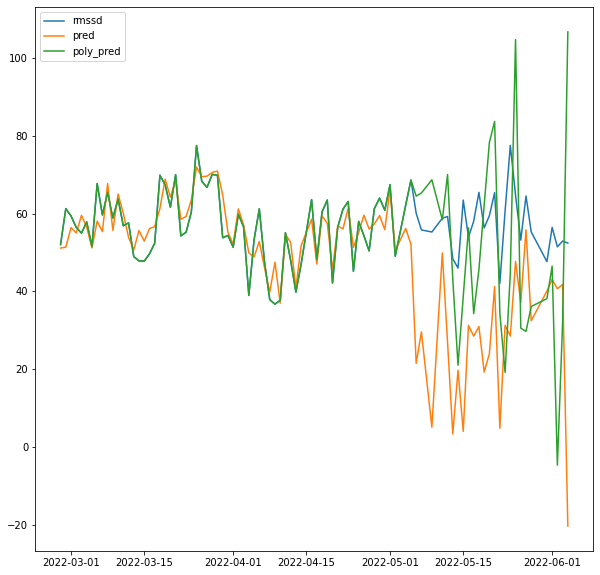

In [153]:
plt.plot(final_df, label=final_df.columns)
plt.legend()

In [154]:
lag_df = lag_df.interpolate(limit_direction='backward')
split_train_df, split_test_df = train_test_split(lag_df, train_size =0.7, \
                                                shuffle=True)
split_train_target = split_train_df['rmssd']
split_test_target = split_test_df['rmssd']

split_train_feature = split_train_df.drop(columns='rmssd')
split_test_feature = split_test_df.drop(columns='rmssd')

poly_test_index = split_test_target.index

poly_split_train_feature = poly.fit_transform(split_train_feature)
poly_split_test_feature = poly.fit_transform(split_test_feature)

In [155]:
split_poly_model = LinearRegression()
split_poly_model.fit(poly_split_train_feature, split_train_target)

LinearRegression()

In [156]:
poly_result = lag_df.copy()
_tmp = poly_result.drop(columns='rmssd')
poly_tmp = poly.fit_transform(_tmp)

poly_random_pred = split_poly_model.predict(poly_tmp)
poly_result['poly_random_pred'] = poly_random_pred

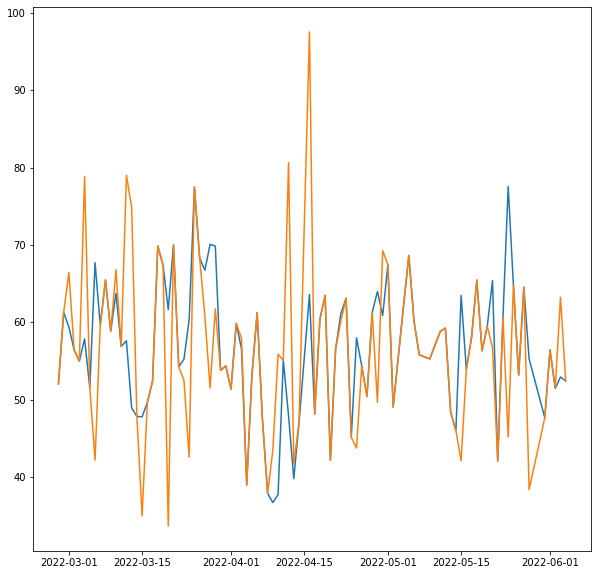

In [157]:
plt.plot(poly_result[['rmssd', 'poly_random_pred']], label=['rmssd', \
                                                            'poly_random_pred'])

In [158]:
poly_random_test_pred = split_poly_model.predict(poly_split_test_feature)
split_poly_model.score(poly_split_test_feature, split_test_target)

-2.495331857841156

In [159]:
metrics.mean_squared_error(split_test_target, poly_random_test_pred, squared=False)

17.981491923530402

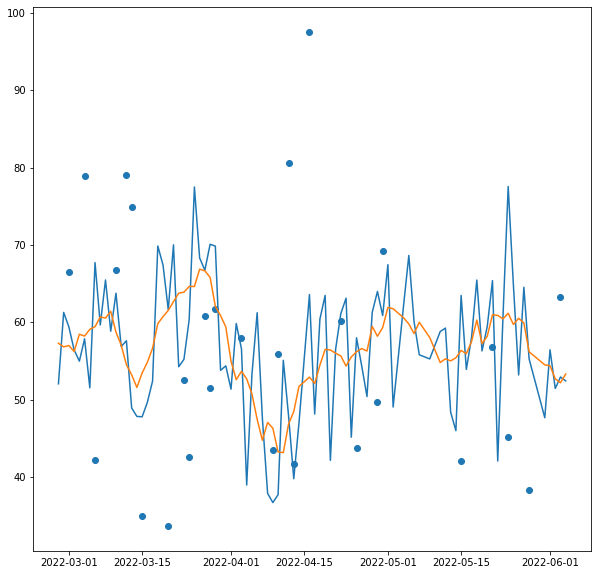

In [160]:
plt.plot(lag_df['rmssd'])
plt.plot(lag_df['hrv_rolling'])
plt.scatter(poly_test_index, poly_random_test_pred)

Dissapointing results, the prediction is way off.

## Stochastic Grafient Decent Regressor

In [161]:
sgd_model = SGDRegressor(learning_rate = 'constant', eta0 = 0.00000000000000000005, verbose=0, max_iter = 1000)
sgd_model.fit(X = poly_split_train_feature, y = split_train_target)

/home/shiya/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDRegressor(eta0=5e-20, learning_rate='constant')

In [162]:
sgd_result = lag_df.copy()
sgd_tmp = sgd_result.drop(columns='rmssd')
display(sgd_tmp)
sgd_tmp = poly.fit_transform(sgd_tmp)

sgd_random_pred = sgd_model.predict(sgd_tmp)
poly_result['sgd_random_pred'] = sgd_random_pred

,nremhr,entropy,hrv_rolling,steps,steps_normalized,steps_rolling,minutesAsleep,minutesAsleep_normalized,minutesAsleep_rolling,Fat_burn_minutes,...,rmssd_lag1,rmssd_lag2,rmssd_lag3,rmssd_lag4,rmssd_lag5,rmssd_lag6,rmssd_lag7,rmssd_lag8,rmssd_lag9,rmssd_lag10
2022-02-27,53.789,2.833,57.290750,2542,25.42,65.727500,395,39.5,35.950000,49.0,...,52.053,52.053,52.053,52.053,52.053,52.053,52.053,52.053,52.053,52.053
2022-02-28,49.983,2.935,56.829000,6426,64.26,74.984000,328,32.8,34.500000,74.0,...,52.053,52.053,52.053,52.053,52.053,52.053,52.053,52.053,52.053,52.053
2022-03-01,50.798,2.943,57.001500,9602,96.02,73.248333,321,32.1,35.333333,301.0,...,61.281,52.053,52.053,52.053,52.053,52.053,52.053,52.053,52.053,52.053
2022-03-02,54.837,2.829,56.220143,7721,77.21,65.765714,394,39.4,38.057143,63.0,...,59.392,61.281,52.053,52.053,52.053,52.053,52.053,52.053,52.053,52.053
2022-03-03,52.368,2.927,58.457857,11201,112.01,66.738571,287,28.7,39.114286,134.0,...,56.437,59.392,61.281,52.053,52.053,52.053,52.053,52.053,52.053,52.053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,56.233,2.883,54.501571,2925,29.25,36.010000,425,42.5,49.257143,48.0,...,55.275,64.533,53.198,64.780,77.557,60.643,42.069,65.393,59.480,56.305
2022-06-01,52.769,2.938,54.392000,15028,150.28,33.932857,334,33.4,49.942857,519.0,...,47.665,55.275,64.533,53.198,64.780,77.557,60.643,42.069,65.393,59.480
2022-06-02,56.017,2.938,52.701833,563,5.63,37.328333,573,57.3,50.433333,3.0,...,56.450,47.665,55.275,64.533,53.198,64.780,77.557,60.643,42.069,65.393
2022-06-03,54.560,2.840,52.187200,3215,32.15,43.846000,619,61.9,49.560000,187.0,...,51.455,56.450,47.665,55.275,64.533,53.198,64.780,77.557,60.643,42.069


## Plot for Stochastic Gradient Descent Regressor

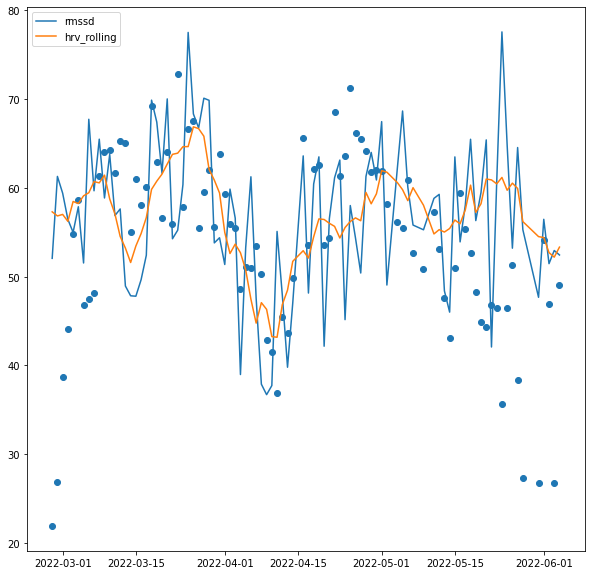

In [163]:
plt.plot(poly_result[['rmssd', 'hrv_rolling']], \
         label = ['rmssd', 'hrv_rolling'])
plt.scatter(poly_result.index, poly_result['sgd_random_pred'])
# plt.plot(poly_result['poly_random_pred'], label = ['poly_random_pred'])
plt.legend()

The prediction kind of makes sense, one downward trend predicted, but way off in the beginning and end.

## Using autogluon, a package that test multiple models, including ensemble models, which takes the average of combined models.

In [164]:
_lag_df = lag_df.drop(columns = ['nremhr', 'entropy', 'hrv_rolling', 'steps_normalized', \
                       'steps_rolling', 'minutesAsleep_normalized', 'minutesAsleep_rolling'])
gluon_train, gluon_test = train_test_split(_lag_df, train_size=0.7)

In [165]:
gluon_data = TabularDataset(gluon_train)
gluon_predictor = TabularPredictor(label='rmssd').fit(gluon_data, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20220608_201445/"
Presets specified: ['best_quality']
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220608_201445/"
AutoGluon Version:  0.4.0
Python Version:     3.9.7
Operating System:   Linux
Train Data Rows:    64
Train Data Columns: 76
Label Column: rmssd
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (77.557, 36.699, 56.25394, 9.10577)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    3719.98 MB
	Train Data (Original)  Memory Usage: 0.04 MB (0.0% of 

In [166]:
gluon_prediction = gluon_predictor.predict(lag_df)
gluon_test_prediction = gluon_predictor.predict(gluon_test)

In [167]:
gluon_prediction_index = gluon_test.index
gluon_prediction_df = gluon_test_prediction
gluon_prediction_df.index = gluon_prediction_index

## Plot before dropping uninportant features

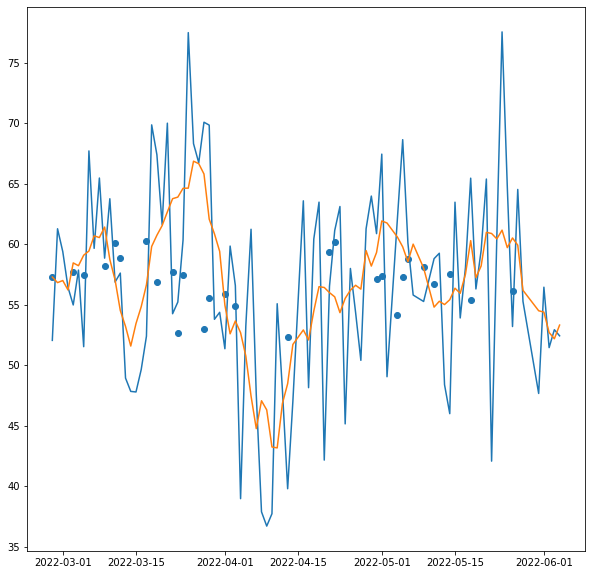

In [168]:
plt.plot(lag_df['rmssd'])
plt.plot(lag_df['hrv_rolling'])
plt.scatter(gluon_test_prediction.index, gluon_test_prediction.values)

Lowest rmssd was taken to be the average of HRV or overall period, gave up on predicting trend.

In [169]:
gluon_predictor.evaluate(gluon_test)

Evaluation: root_mean_squared_error on test data: -7.405250305322229
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -7.405250305322229,
    "mean_squared_error": -54.83773208447496,
    "mean_absolute_error": -5.86920223236084,
    "r2": -0.11605903107403015,
    "pearsonr": -0.002697837804629205,
    "median_absolute_error": -3.5830870971679687
}


{'root_mean_squared_error': -7.405250305322229,
 'mean_squared_error': -54.83773208447496,
 'mean_absolute_error': -5.86920223236084,
 'r2': -0.11605903107403015,
 'pearsonr': -0.002697837804629205,
 'median_absolute_error': -3.5830870971679687}

## Attempt on discarding unimportant features (importance < 0 and p-value > 0.5).

gluon_feature_summary = gluon_predictor.feature_importance(gluon_test)

In [170]:
gluon_feature_summary

,importance,stddev,p_value,n,p99_high,p99_low
minutesAsleep_lag3,0.249560,0.023503,0.001472,3,0.384233,0.114888
Cardio_minutes,0.109991,0.040315,0.020990,3,0.340998,-0.121016
minutesAsleep,0.044914,0.041299,0.100151,3,0.281563,-0.191735
minutesAsleep_lag6,0.042527,0.021470,0.037733,3,0.165552,-0.080497
rmssd_lag10,0.038211,0.016975,0.029964,3,0.135478,-0.059056
...,...,...,...,...,...,...
Resting_minutes_lag5,-0.054822,0.024467,0.969781,3,0.085377,-0.195020
Fat_burn_minutes_lag2,-0.055664,0.012139,0.992257,3,0.013896,-0.125224
Peak_minutes_lag3,-0.078832,0.054842,0.934759,3,0.235416,-0.393081
Peak_minutes_lag1,-0.088884,0.016853,0.994114,3,0.007685,-0.185453


In [171]:
useless_columns = gluon_feature_summary\
                [(gluon_feature_summary['importance'] < 0) \
                & (gluon_feature_summary['p_value']> 0.5)].index

In [172]:
useless_columns

Index(['Resting_minutes_lag7', 'minutesAsleep_lag5', 'rmssd_lag5',
       'Peak_minutes_lag4', 'Peak_minutes_lag8', 'rmssd_lag7',
       'Resting_minutes_lag2', 'Cardio_minutes_lag8', 'rmssd_lag2',
       'Cardio_minutes_lag9', 'Cardio_minutes_lag1', 'rmssd_lag6',
       'Fat_burn_minutes_lag4', 'Fat_burn_minutes_lag3', 'steps_lag5',
       'Peak_minutes_lag9', 'Fat_burn_minutes_lag9', 'Fat_burn_minutes_lag1',
       'Fat_burn_minutes_lag7', 'steps_lag4', 'Cardio_minutes_lag3',
       'Peak_minutes_lag6', 'steps_lag7', 'rmssd_lag8', 'Resting_minutes_lag9',
       'Resting_minutes_lag1', 'Cardio_minutes_lag7', 'Cardio_minutes_lag6',
       'Cardio_minutes_lag4', 'Peak_minutes_lag2', 'minutesAsleep_lag2',
       'Cardio_minutes_lag2', 'steps', 'steps_lag10', 'Cardio_minutes_lag10',
       'Resting_minutes_lag5', 'Fat_burn_minutes_lag2', 'Peak_minutes_lag3',
       'Peak_minutes_lag1', 'rmssd_lag9'],
      dtype='object')

In [173]:
_dropped_df = _lag_df.copy()
for col in useless_columns:
    _dropped_df.drop(columns=col, inplace=True)

In [174]:
_dropped_df

,rmssd,minutesAsleep,Fat_burn_minutes,Cardio_minutes,Peak_minutes,Resting_minutes,steps_lag1,steps_lag2,steps_lag3,steps_lag6,...,Peak_minutes_lag7,Peak_minutes_lag10,Fat_burn_minutes_lag5,Fat_burn_minutes_lag6,Fat_burn_minutes_lag8,Fat_burn_minutes_lag10,rmssd_lag1,rmssd_lag3,rmssd_lag4,rmssd_lag10
2022-02-27,52.053,395,49.0,2.0,0.0,1375.0,2542.0,2542.0,2542.0,2542.0,...,0.0,0.0,49.0,49.0,49.0,49.0,52.053,52.053,52.053,52.053
2022-02-28,61.281,328,74.0,1.0,0.0,1327.0,2542.0,2542.0,2542.0,2542.0,...,0.0,0.0,49.0,49.0,49.0,49.0,52.053,52.053,52.053,52.053
2022-03-01,59.392,321,301.0,2.0,0.0,1133.0,6426.0,2542.0,2542.0,2542.0,...,0.0,0.0,49.0,49.0,49.0,49.0,61.281,52.053,52.053,52.053
2022-03-02,56.437,394,63.0,0.0,0.0,1318.0,9602.0,6426.0,2542.0,2542.0,...,0.0,0.0,49.0,49.0,49.0,49.0,59.392,52.053,52.053,52.053
2022-03-03,54.982,287,134.0,0.0,0.0,1261.0,7721.0,9602.0,6426.0,2542.0,...,0.0,0.0,49.0,49.0,49.0,49.0,56.437,61.281,52.053,52.053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,47.665,425,48.0,0.0,0.0,1199.0,474.0,1356.0,1646.0,1245.0,...,0.0,0.0,24.0,220.0,54.0,273.0,55.275,53.198,64.780,56.305
2022-06-01,56.450,334,519.0,5.0,0.0,908.0,2925.0,474.0,1356.0,1868.0,...,8.0,0.0,60.0,24.0,13.0,135.0,47.665,64.533,53.198,59.480
2022-06-02,51.455,573,3.0,0.0,0.0,862.0,15028.0,2925.0,474.0,2765.0,...,0.0,0.0,17.0,60.0,220.0,54.0,56.450,55.275,64.533,65.393
2022-06-03,52.935,619,187.0,13.0,0.0,1044.0,563.0,15028.0,2925.0,1646.0,...,2.0,0.0,5.0,17.0,24.0,13.0,51.455,47.665,55.275,42.069


In [175]:
dropped_train, dropped_test = train_test_split(_dropped_df, train_size = 0.8)
dropped_gluon_data = TabularDataset(dropped_train)
dropped_gluon_predictor = TabularPredictor(label='rmssd').fit(dropped_gluon_data, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20220608_201516/"
Presets specified: ['best_quality']
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220608_201516/"
AutoGluon Version:  0.4.0
Python Version:     3.9.7
Operating System:   Linux
Train Data Rows:    73
Train Data Columns: 36
Label Column: rmssd
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (77.557, 36.699, 57.41392, 8.5538)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    3677.57 MB
	Train Data (Original)  Memory Usage: 0.02 MB (0.0% of a

In [176]:
dropped_gluon_prediction = dropped_gluon_predictor.predict(lag_df)
dropped_gluon_test_prediction = dropped_gluon_predictor.predict(dropped_test)

In [177]:
dropped_gluon_prediction_index = dropped_test.index
dropped_gluon_prediction_df = dropped_gluon_test_prediction
dropped_gluon_prediction_df.index = dropped_gluon_prediction_index

## Prediction after dropping features.

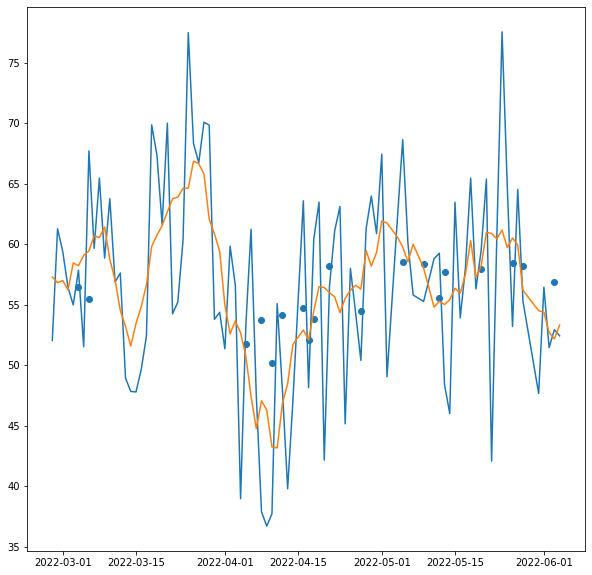

In [178]:
plt.plot(lag_df['rmssd'])
plt.plot(lag_df['hrv_rolling'])
plt.scatter(dropped_gluon_test_prediction.index, dropped_gluon_test_prediction.values)

Dead end, no idea how to intepret the results.

In [179]:
dropped_feature = dropped_gluon_predictor.feature_importance(dropped_test)

Computing feature importance via permutation shuffling for 36 features using 19 rows with 3 shuffle sets...
	16.99s	= Expected runtime (5.66s per shuffle set)
	1.54s	= Actual runtime (Completed 3 of 3 shuffle sets)


In [180]:
dropped_feature.index

Index(['minutesAsleep_lag3', 'Cardio_minutes', 'minutesAsleep_lag7',
       'rmssd_lag3', 'Fat_burn_minutes', 'minutesAsleep', 'minutesAsleep_lag8',
       'minutesAsleep_lag4', 'rmssd_lag1', 'Fat_burn_minutes_lag5',
       'minutesAsleep_lag9', 'rmssd_lag10', 'minutesAsleep_lag6',
       'Resting_minutes_lag6', 'steps_lag6', 'steps_lag2',
       'Resting_minutes_lag3', 'Peak_minutes_lag7', 'Peak_minutes',
       'Fat_burn_minutes_lag8', 'Peak_minutes_lag10', 'Peak_minutes_lag5',
       'Resting_minutes_lag8', 'rmssd_lag4', 'Cardio_minutes_lag5',
       'Resting_minutes', 'Fat_burn_minutes_lag6', 'steps_lag3', 'steps_lag9',
       'steps_lag8', 'minutesAsleep_lag1', 'Fat_burn_minutes_lag10',
       'minutesAsleep_lag10', 'Resting_minutes_lag4', 'Resting_minutes_lag10',
       'steps_lag1'],
      dtype='object')

In [181]:
dropped_feature

,importance,stddev,p_value,n,p99_high,p99_low
minutesAsleep_lag3,0.450802,0.036743,0.001104,3,0.661341,0.240263
Cardio_minutes,0.150156,0.235763,0.192477,3,1.501102,-1.200791
minutesAsleep_lag7,0.141971,0.151673,0.123207,3,1.011073,-0.727132
rmssd_lag3,0.136488,0.127597,0.102553,3,0.867636,-0.594659
Fat_burn_minutes,0.099345,0.110268,0.129510,3,0.731192,-0.532502
...,...,...,...,...,...,...
Fat_burn_minutes_lag10,-0.024881,0.108250,0.635485,3,0.595405,-0.645167
minutesAsleep_lag10,-0.036827,0.123141,0.671964,3,0.668785,-0.742438
Resting_minutes_lag4,-0.041230,0.090206,0.744232,3,0.475661,-0.558121
Resting_minutes_lag10,-0.047640,0.026405,0.955523,3,0.103666,-0.198945
